In [21]:
import pandas as pd
import numpy as np
import re


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score

# NLTK
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/paulmuller/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/paulmuller/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/paulmuller/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/paulmuller/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
print(nltk.data.path)

['/Users/paulmuller/nltk_data', '/opt/anaconda3/nltk_data', '/opt/anaconda3/share/nltk_data', '/opt/anaconda3/lib/nltk_data', '/usr/share/nltk_data', '/usr/local/share/nltk_data', '/usr/lib/nltk_data', '/usr/local/lib/nltk_data']


In [23]:
# Load the dataset (update file path accordingly)
data_file = "training_data_lowercase.csv"
data = pd.read_csv(data_file, sep="\t", header=None)  # Tab-separated

In [24]:
data.columns = ['label', 'text'] 

data.head(5)

,label,text
0,0,donald trump sends out embarrassing new year‚s...
1,0,drunk bragging trump staffer started russian c...
2,0,sheriff david clarke becomes an internet joke ...
3,0,trump is so obsessed he even has obama‚s name ...
4,0,pope francis just called out donald trump duri...


In [25]:
data['text'] = data['text'].str.replace(r'[^a-zA-Z0-9\s]', '', regex=True)

In [26]:
stop_words = set(stopwords.words('english'))

In [27]:
# Tokenize and remove stopwords
data['filtered_text'] = data['text'].apply(lambda x: [word for word in word_tokenize(x.lower()) if word not in stop_words])

In [28]:
# Lemmatization of text to leverage the context as well

# from nltk.stem import WordNetLemmatizer
# from nltk.corpus import wordnet

# Initialize the lemmatizer
lemmatizer = WordNetLemmatizer()

# Function to get part-of-speech (POS) tagging for more accurate lemmatization
def get_wordnet_pos(word):
    from nltk.corpus import wordnet
    from nltk import pos_tag
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {
        'J': wordnet.ADJ,  # Adjective
        'N': wordnet.NOUN,  # Noun
        'V': wordnet.VERB,  # Verb
        'R': wordnet.ADV   # Adverb
    }
    return tag_dict.get(tag, wordnet.NOUN)  # Default to noun

# Apply lemmatization to the filtered_text column
data['lemmatized_text'] = data['filtered_text'].apply(
    lambda tokens: [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in tokens]
)

# Display the first few rows to verify the result
print(data.head())


   label                                               text  \
0      0  donald trump sends out embarrassing new years ...   
1      0  drunk bragging trump staffer started russian c...   
2      0  sheriff david clarke becomes an internet joke ...   
3      0  trump is so obsessed he even has obamas name c...   
4      0  pope francis just called out donald trump duri...   

                                       filtered_text  \
0  [donald, trump, sends, embarrassing, new, year...   
1  [drunk, bragging, trump, staffer, started, rus...   
2  [sheriff, david, clarke, becomes, internet, jo...   
3  [trump, obsessed, even, obamas, name, coded, w...   
4  [pope, francis, called, donald, trump, christm...   

                                     lemmatized_text  
0  [donald, trump, sends, embarrass, new, year, e...  
1  [drunk, bragging, trump, staffer, start, russi...  
2  [sheriff, david, clarke, becomes, internet, jo...  
3  [trump, obsess, even, obamas, name, cod, websi...  
4  [pope,

In [29]:
# Combine tokens into single text strings for each row in 'lemmatized_text'
data['lemmatized_text'] = data['lemmatized_text'].apply(lambda tokens: ' '.join(tokens))

In [30]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(
    max_features=10000,  # Adjust as needed
    stop_words='english',  # Ignore common stopwords
    ngram_range=(1, 2)  # Unigrams and bigrams
)

print(data['lemmatized_text'])

0        donald trump sends embarrass new year eve mess...
1        drunk bragging trump staffer start russian col...
2        sheriff david clarke becomes internet joke thr...
3          trump obsess even obamas name cod website image
4          pope francis call donald trump christmas speech
                               ...                        
34147              tear rain thai gather late king funeral
34148    pyongyang university need nonus teacher travel...
34149    philippine president duterte visit japan ahead...
34150             japan abe may election many dont want pm
34151      demoralize divide inside catalonia police force
Name: lemmatized_text, Length: 34152, dtype: object


In [31]:
# Fit and transform the lemmatized text column
tfidf_matrix = tfidf_vectorizer.fit_transform(data['lemmatized_text'])

print(data['lemmatized_text'])

0        donald trump sends embarrass new year eve mess...
1        drunk bragging trump staffer start russian col...
2        sheriff david clarke becomes internet joke thr...
3          trump obsess even obamas name cod website image
4          pope francis call donald trump christmas speech
                               ...                        
34147              tear rain thai gather late king funeral
34148    pyongyang university need nonus teacher travel...
34149    philippine president duterte visit japan ahead...
34150             japan abe may election many dont want pm
34151      demoralize divide inside catalonia police force
Name: lemmatized_text, Length: 34152, dtype: object


In [32]:
# Convert the resulting sparse matrix to a DataFrame for analysis
tfidf_df = pd.DataFrame(
    tfidf_matrix.toarray(), 
    columns=tfidf_vectorizer.get_feature_names_out() )

In [33]:
# Display the first few rows of the TF-IDF DataFrame
print(tfidf_df.head(50))

     10  10 billion  10 day  10 million  10 year  100  100 day  100 million  \
0   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
1   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
2   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
3   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
4   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
5   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
6   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
7   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
8   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
9   0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
10  0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
11  0.0         0.0     0.0         0.0      0.0  0.

In [34]:
print(data['lemmatized_text'].head(10))
print(data['lemmatized_text'].isna().sum())  # Check for NaN values
print(data['lemmatized_text'].apply(len).describe())  # Analyze lengths of text

0    donald trump sends embarrass new year eve mess...
1    drunk bragging trump staffer start russian col...
2    sheriff david clarke becomes internet joke thr...
3      trump obsess even obamas name cod website image
4      pope francis call donald trump christmas speech
5    racist alabama cop brutalize black boy handcuf...
6                                    fresh golf course
7    trump say insanely racist stuff inside oval of...
8           former cia director slam trump un bullying
9     brandnew protrump ad feature much kiss make sick
Name: lemmatized_text, dtype: object
0
count    34152.000000
mean        59.053994
std         17.685429
min          0.000000
25%         49.000000
50%         57.000000
75%         67.000000
max        229.000000
Name: lemmatized_text, dtype: float64


In [35]:
X = tfidf_df  # Feature set
y = data['label']  
# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
# Train Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# Predict and evaluate
y_pred_lr = log_reg.predict(X_test)
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Classification Report:\n", classification_report(y_test, y_pred_lr))

Logistic Regression Accuracy: 0.9285609720392329
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93      3529
           1       0.92      0.94      0.93      3302

    accuracy                           0.93      6831
   macro avg       0.93      0.93      0.93      6831
weighted avg       0.93      0.93      0.93      6831



In [37]:
# Train Decision Tree Classifier
tree_clf = DecisionTreeClassifier()
tree_clf.fit(X_train, y_train)

# Predict and evaluate
y_pred_tree = tree_clf.predict(X_test)
print("Decision Tree Accuracy:", accuracy_score(y_test, y_pred_tree))
print("Classification Report:\n", classification_report(y_test, y_pred_tree))

Decision Tree Accuracy: 0.8685404772361294
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87      3529
           1       0.86      0.87      0.86      3302

    accuracy                           0.87      6831
   macro avg       0.87      0.87      0.87      6831
weighted avg       0.87      0.87      0.87      6831



In [38]:
print("Number of NaN values:", data['lemmatized_text'].isna().sum())

Number of NaN values: 0


In [39]:
print(data['lemmatized_text'].apply(len).describe())

count    34152.000000
mean        59.053994
std         17.685429
min          0.000000
25%         49.000000
50%         57.000000
75%         67.000000
max        229.000000
Name: lemmatized_text, dtype: float64


In [40]:
print("TF-IDF Features:\n", tfidf_df.head())

TF-IDF Features:
     10  10 billion  10 day  10 million  10 year  100  100 day  100 million  \
0  0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
1  0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
2  0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
3  0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   
4  0.0         0.0     0.0         0.0      0.0  0.0      0.0          0.0   

   100 percent  1000  ...  zimbabwe opposition  zimbabwe ruling  zimbabwean  \
0          0.0   0.0  ...                  0.0              0.0         0.0   
1          0.0   0.0  ...                  0.0              0.0         0.0   
2          0.0   0.0  ...                  0.0              0.0         0.0   
3          0.0   0.0  ...                  0.0              0.0         0.0   
4          0.0   0.0  ...                  0.0              0.0         0.0   

   zimmerman  zing  zone  zoo  zuckerb

## Bayes Model / Paul 

In [55]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# Naive Bayes Modell
bayes_model = GaussianNB()
bayes_model.fit(X_train_scaled, y_train)

# Vorhersagen
y_pred = bayes_model.predict(X_test_scaled)

# Genauigkeit
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.8454106280193237


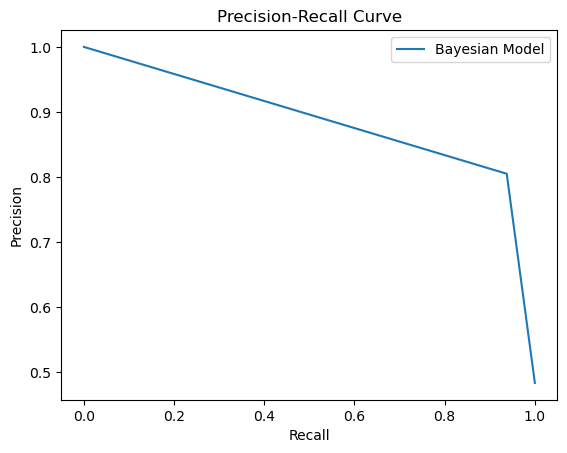

In [56]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

precision, recall, _ = precision_recall_curve(y_test, predictions3)
plt.plot(recall, precision, label="Bayesian Model")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


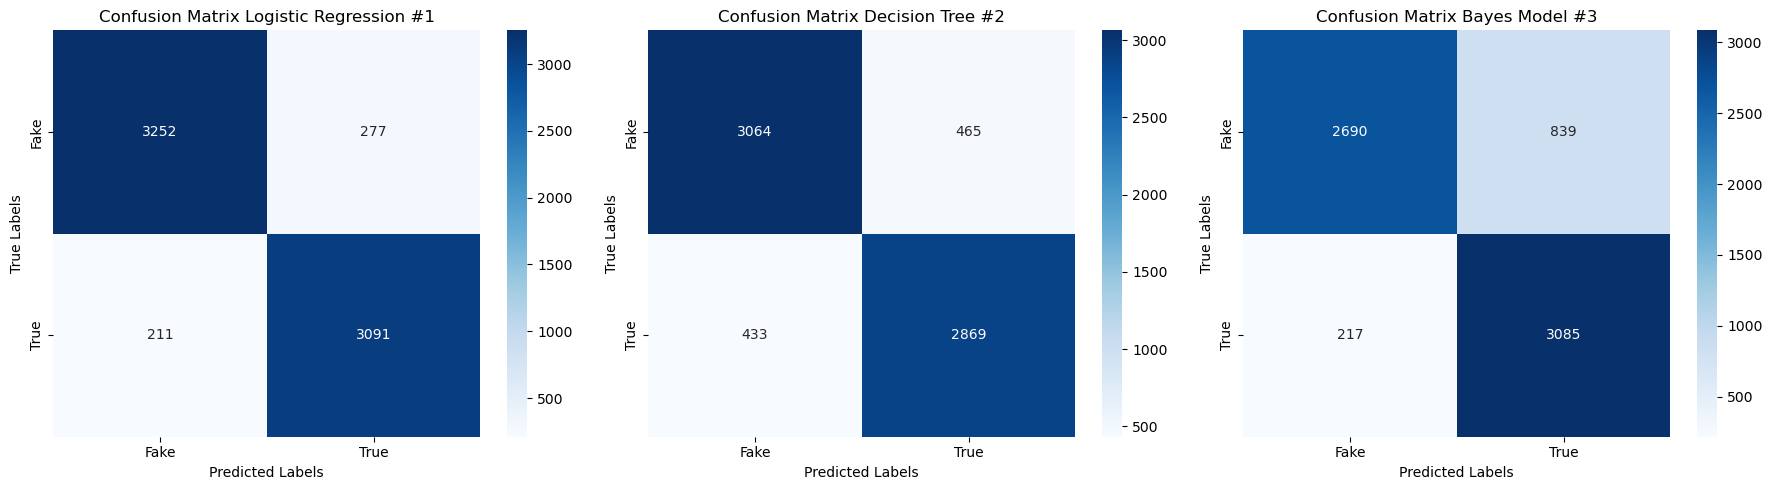

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# Define class names
class_names = ['Fake', 'True']

# Predictions and ground truth for model #1
predictions1 = log_reg.predict(X_test)  # Logistic Regression predictions
cm1 = confusion_matrix(y_test, predictions1)

# Predictions and ground truth for model #2
predictions2 = tree_clf.predict(X_test)  # Decision Tree predictions
cm2 = confusion_matrix(y_test, predictions2)

# Predictions and ground truth for model #3
predictions3 = bayes_model.predict(X_test_scaled)  # Bayesian predictions
cm3 = confusion_matrix(y_test, predictions3)

# Create subplots for all three models
fig, axs = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Plot Confusion Matrix for Model #1
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axs[0])
axs[0].set_title('Confusion Matrix Logistic Regression #1')
axs[0].set_xlabel('Predicted Labels')
axs[0].set_ylabel('True Labels')

# Plot Confusion Matrix for Model #2
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axs[1])
axs[1].set_title('Confusion Matrix Decision Tree #2')
axs[1].set_xlabel('Predicted Labels')
axs[1].set_ylabel('True Labels')

# Plot Confusion Matrix for Model #3
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axs[2])
axs[2].set_title('Confusion Matrix Bayes Model #3')
axs[2].set_xlabel('Predicted Labels')
axs[2].set_ylabel('True Labels')

# Adjust layout to ensure proper spacing
plt.tight_layout()
plt.show()


In [64]:
import pandas as pd

# Calculate Accuracy for Each Model
accuracy_lr = accuracy_score(y_test, predictions1)
accuracy_tree = accuracy_score(y_test, predictions2)
accuracy_bayes = accuracy_score(y_test, predictions3)

# Extract Feature Importance for Vectorizer
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_features = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

# Top Features from the Vectorizer (example: sum across columns)
feature_importance = tfidf_features.sum(axis=0).sort_values(ascending=False).head(10)

# Create a Summary Table
summary_table = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Bayesian Model'],
    'Accuracy': [accuracy_lr, accuracy_tree, accuracy_bayes],
    'Top Feature': [feature_importance.index[0], feature_importance.index[0], feature_importance.index[0]]
})

print(summary_table)


                 Model  Accuracy Top Feature
0  Logistic Regression  0.928561       trump
1        Decision Tree  0.868540       trump
2       Bayesian Model  0.845411       trump


### Comparison of Accuracy Across Models



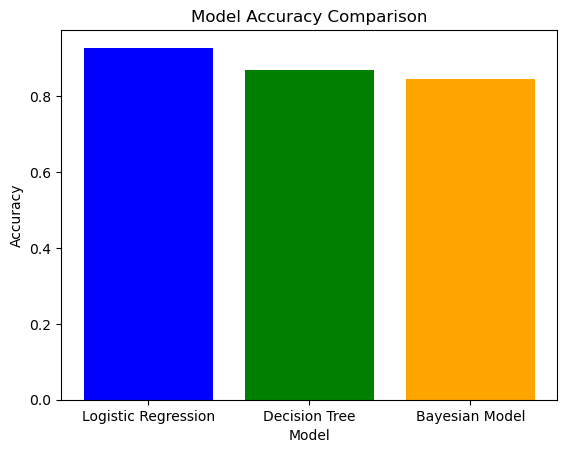

In [65]:
import matplotlib.pyplot as plt

models = ['Logistic Regression', 'Decision Tree', 'Bayesian Model']
accuracies = [accuracy_lr, accuracy_tree, accuracy_bayes]

plt.bar(models, accuracies, color=['blue', 'green', 'orange'])
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Comparison")
plt.show()


# Stacking Test

In [72]:
from sklearn.ensemble import StackingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Define base models
base_models = [
    ('log_reg', LogisticRegression(max_iter=1000)),
    ('decision_tree', DecisionTreeClassifier()),
    ('bayes', GaussianNB())
]

# Define meta-model
meta_model = LogisticRegression(max_iter=1000)

# Create stacking classifier
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model, cv=5)

# Train stacking model
stacking_clf.fit(X_train, y_train)

# Predict and evaluate
stacking_predictions = stacking_clf.predict(X_test)
stacking_accuracy = accuracy_score(y_test, stacking_predictions)

print(f"Stacking Model Accuracy: {stacking_accuracy:.2f}")


Stacking Model Accuracy: 0.93


## Bagging Ensemble


In [66]:
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score

# Create bagging classifier using Bayesian Model
bagging_clf = BaggingClassifier(estimator=GaussianNB(), n_estimators=10, random_state=42)

# Train the model
bagging_clf.fit(X_train, y_train)

# Predict and evaluate
bagging_predictions = bagging_clf.predict(X_test)
bagging_accuracy = accuracy_score(y_test, bagging_predictions)

print(f"Bagging Model Accuracy: {bagging_accuracy:.2f}")


Bagging Model Accuracy: 0.87


## Blending (Alternative to Stacking)

In [67]:
from sklearn.model_selection import train_test_split
import numpy as np

# Split training data for blending
X_blend_train, X_meta, y_blend_train, y_meta = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Train base models
log_reg.fit(X_blend_train, y_blend_train)
tree_clf.fit(X_blend_train, y_blend_train)
bayes_model.fit(X_blend_train, y_blend_train)

# Get predictions from base models
log_reg_preds = log_reg.predict_proba(X_meta)[:, 1]
tree_clf_preds = tree_clf.predict_proba(X_meta)[:, 1]
bayes_preds = bayes_model.predict_proba(X_meta)[:, 1]

# Combine predictions as features for meta-model
meta_features = np.column_stack((log_reg_preds, tree_clf_preds, bayes_preds))

# Train meta-model
meta_model.fit(meta_features, y_meta)

# Final prediction using meta-model
test_meta_features = np.column_stack((
    log_reg.predict_proba(X_test)[:, 1],
    tree_clf.predict_proba(X_test)[:, 1],
    bayes_model.predict_proba(X_test)[:, 1]
))
blended_predictions = meta_model.predict(test_meta_features)
blended_accuracy = accuracy_score(y_test, blended_predictions)

print(f"Blended Model Accuracy: {blended_accuracy:.2f}")


Blended Model Accuracy: 0.93


### Comparison of Stacking, Bagging, and Blending

In [73]:
summary_table = pd.DataFrame({
    'Model': ['Logistic Regression', 'Decision Tree', 'Bayesian Model', 'Stacking', 'Bagging', 'Blending'],
    'Accuracy': [accuracy_lr, accuracy_tree, accuracy_bayes, stacking_accuracy, bagging_accuracy, blended_accuracy]
})

print(summary_table)


                 Model  Accuracy
0  Logistic Regression  0.928561
1        Decision Tree  0.868540
2       Bayesian Model  0.845411
3             Stacking  0.934993
4              Bagging  0.867955
5             Blending  0.931782


In [69]:
from sklearn.model_selection import KFold
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Define the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Bayesian Model": GaussianNB(),
    "Fourth Model": LogisticRegression(max_iter=1000)  # Replace with your fourth model
}

# Set up K-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)  # 5 folds

# To store results
model_accuracies = {name: [] for name in models}

# Perform K-Fold Splitting and Training
for train_index, test_index in kf.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Train and evaluate each model
    for model_name, model in models.items():
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        model_accuracies[model_name].append(accuracy)

# Calculate mean accuracy for each model
mean_accuracies = {name: sum(scores) / len(scores) for name, scores in model_accuracies.items()}

# Print results
for model_name, mean_accuracy in mean_accuracies.items():
    print(f"{model_name}: Mean Accuracy = {mean_accuracy:.2f}")


Logistic Regression: Mean Accuracy = 0.93
Decision Tree: Mean Accuracy = 0.86
Bayesian Model: Mean Accuracy = 0.86
Fourth Model: Mean Accuracy = 0.93
